In [1]:
# !pip install df2img

In [2]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

import matplotlib.pyplot as plt
import datetime
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# # 데이터프레임을 그림 파일로 저장
# option = 2 # 1 : dfi / 2 : df2img
# import df2img
# def savedf(df, path):
#     if option == 1:
#         dfi.export(df, path)
#     if option == 2:
#         df2img.save_dataframe(fig=df2img.plot_dataframe(df), filename=path)

In [53]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:\Windows\Fonts\malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 데이터 전처리

In [4]:
# 해커톤 데이터 불러오기 및 이름 수정
hackathon_data_original = pd.read_csv("../../data/20211022_수요예측_hackathon_data.csv", encoding='cp949')
hackathon_data_original['region2'].replace({ 
    '수원시\u3000팔달구':'수원시 팔달구', '수원시\u3000영통구':'수원시 영통구', '용인시\u3000기흥구':'용인시 기흥구',
    '고양시\u3000일산동구':'고양시 일산동구', '안양시\u3000동안구':'안양시 동안구', '고양시\u3000일산서구':'고양시 일산서구',
    '성남시\u3000수정구':'성남시 수정구', '수원시\u3000장안구':'수원시 장안구', '성남시\u3000중원구':'성남시 중원구',
    '안산시\u3000단원구':'안산시 단원구', '용인시\u3000수지구':'용인시 수지구', '고양시\u3000덕양구':'고양시 덕양구',
    '용인시\u3000처인구':'용인시 처인구', '안양시\u3000만안구':'안양시 만안구', '성남시\u3000분당구':'성남시 분당구',
    '수원시\u3000권선구':'수원시 권선구', '안산시\u3000상록구':'안산시 상록구',}, inplace=True)
hackathon_data_original['reservation_return_at'] = pd.to_datetime(hackathon_data_original['reservation_return_at'])
hackathon_data_original['reservation_start_at'] = pd.to_datetime(hackathon_data_original['reservation_start_at'])
hackathon_data_original.head()

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형


In [5]:
# 경기도 데이터
gyeong_gi = hackathon_data_original[hackathon_data_original['region1']=='경기도']

In [6]:
gyeong_gi['used_time'] = gyeong_gi['reservation_return_at'] - gyeong_gi['reservation_start_at']
gyeong_gi['reservation_return_date'] = gyeong_gi['reservation_return_at'].dt.to_period(freq = 'D')
gyeong_gi['reservation_start_date'] = gyeong_gi['reservation_start_at']. dt.to_period(freq = 'D')
gyeong_gi['week'] = gyeong_gi['reservation_start_date'].dt.dayofweek
gyeong_gi

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1,male,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4,male,준중형SUV,0 days 23:50:00,2019-05-14,2019-05-13,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1,male,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3,female,소형SUV,0 days 09:24:19,2019-04-07,2019-04-07,6
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2,male,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4
...,...,...,...,...,...,...,...,...,...,...,...
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,male,경형,0 days 00:25:29,2019-09-14,2019-09-14,5
457063,경기도,고양시 일산서구,2019-07-25 15:30:00+00:00,2019-07-24 18:30:00+00:00,4,female,준중형,0 days 21:00:00,2019-07-25,2019-07-24,2
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,male,경형,0 days 01:08:09,2019-07-14,2019-07-14,6
457065,경기도,고양시 일산서구,2019-06-20 18:25:37+00:00,2019-06-20 18:10:00+00:00,1,unknown,소형SUV,0 days 00:15:37,2019-06-20,2019-06-20,3


In [7]:
gyeong_gi['gender'] = gyeong_gi['gender'].apply(lambda x: 0 if x == 'male' else 1)
gyeong_gi['is_weekend'] = gyeong_gi['week'].apply(lambda x: 0 if x < 5 else 1)
gyeong_gi

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week,is_weekend
44105,경기도,광명시,2019-10-08 12:27:53+00:00,2019-10-07 19:30:00+00:00,1,0,소형SUV,0 days 16:57:53,2019-10-08,2019-10-07,0,0
44106,경기도,광명시,2019-05-14 12:50:00+00:00,2019-05-13 13:00:00+00:00,4,0,준중형SUV,0 days 23:50:00,2019-05-14,2019-05-13,0,0
44107,경기도,광명시,2019-01-11 17:14:14+00:00,2019-01-11 13:30:00+00:00,1,0,소형SUV,0 days 03:44:14,2019-01-11,2019-01-11,4,0
44108,경기도,광명시,2019-04-07 19:54:19+00:00,2019-04-07 10:30:00+00:00,3,1,소형SUV,0 days 09:24:19,2019-04-07,2019-04-07,6,1
44109,경기도,광명시,2019-09-20 22:47:39+00:00,2019-09-20 16:20:00+00:00,2,0,준중형,0 days 06:27:39,2019-09-20,2019-09-20,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
457062,경기도,고양시 일산서구,2019-09-14 12:25:29+00:00,2019-09-14 12:00:00+00:00,1,0,경형,0 days 00:25:29,2019-09-14,2019-09-14,5,1
457063,경기도,고양시 일산서구,2019-07-25 15:30:00+00:00,2019-07-24 18:30:00+00:00,4,1,준중형,0 days 21:00:00,2019-07-25,2019-07-24,2,0
457064,경기도,고양시 일산서구,2019-07-14 22:38:09+00:00,2019-07-14 21:30:00+00:00,1,0,경형,0 days 01:08:09,2019-07-14,2019-07-14,6,1
457065,경기도,고양시 일산서구,2019-06-20 18:25:37+00:00,2019-06-20 18:10:00+00:00,1,1,소형SUV,0 days 00:15:37,2019-06-20,2019-06-20,3,0


In [8]:
cities = gyeong_gi['region2'].unique()
cities

array(['광명시', '구리시', '김포시', '양평군', '하남시', '화성시', '남양주시', '의정부시',
       '고양시 덕양구', '성남시 분당구', '성남시 수정구', '성남시 중원구', '안양시 동안구', '안양시 만안구',
       '고양시 일산동구', '고양시 일산서구'], dtype=object)

In [9]:
cluster_names = ['A', 'B', 'C', 'D', 'E', 'F']
clustering_result = pd.read_csv("../../data/data_c_final/2c203_0126_clustering_result.csv")
clustering_result

,군집,소속도시
0,A,"['용인시 기흥구', '성남시 분당구', '시흥시', '김포시', '고양시 덕양구'..."
1,B,"['수원시 장안구', '수원시 팔달구', '용인시 처인구', '성남시 수정구', '..."
2,C,"['부천시', '화성시', '남양주시']"
3,D,"['양평군', '여주시', '과천시', '포천시', '동두천시', '가평군', '연..."
4,E,"['수원시 권선구', '수원시 영통구', '용인시 수지구', '안산시 상록구', '..."
5,F,['평택시']


In [10]:
# cluster A, cluster B, ..., cluster F
import ast
A = ast.literal_eval(clustering_result['소속도시'][0])
B = ast.literal_eval(clustering_result['소속도시'][1])
C = ast.literal_eval(clustering_result['소속도시'][2])
D = ast.literal_eval(clustering_result['소속도시'][3])
E = ast.literal_eval(clustering_result['소속도시'][4])
F = ast.literal_eval(clustering_result['소속도시'][5])
print("cluster A :", sorted(A))
print("cluster B :", sorted(B))
print("cluster C :", sorted(C))
print("cluster D :", sorted(D))
print("cluster E :", sorted(E))
print("cluster F :", sorted(F))

cluster A : ['고양시 덕양구', '김포시', '성남시 분당구', '시흥시', '용인시 기흥구', '의정부시', '파주시']
cluster B : ['구리시', '군포시', '성남시 수정구', '성남시 중원구', '수원시 장안구', '수원시 팔달구', '안성시', '안양시 만안구', '양주시', '오산시', '용인시 처인구', '의왕시', '이천시']
cluster C : ['남양주시', '부천시', '화성시']
cluster D : ['가평군', '과천시', '동두천시', '양평군', '여주시', '연천군', '포천시']
cluster E : ['고양시 일산동구', '고양시 일산서구', '광명시', '광주시', '수원시 권선구', '수원시 영통구', '안산시 단원구', '안산시 상록구', '안양시 동안구', '용인시 수지구', '하남시']
cluster F : ['평택시']


In [11]:
print("cluster A intersected :", sorted(list(set.intersection(set(A), set(cities)))))
print("cluster B intersected :", sorted(list(set.intersection(set(B), set(cities)))))
print("cluster C intersected :", sorted(list(set.intersection(set(C), set(cities)))))
print("cluster D intersected :", sorted(list(set.intersection(set(D), set(cities)))))
print("cluster E intersected :", sorted(list(set.intersection(set(E), set(cities)))))
print("cluster F intersected :", sorted(list(set.intersection(set(F), set(cities)))))

cluster A intersected : ['고양시 덕양구', '김포시', '성남시 분당구', '의정부시']
cluster B intersected : ['구리시', '성남시 수정구', '성남시 중원구', '안양시 만안구']
cluster C intersected : ['남양주시', '화성시']
cluster D intersected : ['양평군']
cluster E intersected : ['고양시 일산동구', '고양시 일산서구', '광명시', '안양시 동안구', '하남시']
cluster F intersected : []


In [12]:
dataA_original = gyeong_gi[gyeong_gi['region2'].isin(A)]
dataB_original = gyeong_gi[gyeong_gi['region2'].isin(B)]
dataC_original = gyeong_gi[gyeong_gi['region2'].isin(C)]
dataD_original = gyeong_gi[gyeong_gi['region2'].isin(D)]
dataE_original = gyeong_gi[gyeong_gi['region2'].isin(E)]
data_original_ = [dataA_original, dataB_original, dataC_original, dataD_original, dataE_original]
dataA_original

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model,used_time,reservation_return_date,reservation_start_date,week,is_weekend
79761,경기도,김포시,2019-09-01 20:10:10+00:00,2019-09-01 13:30:00+00:00,1,1,경형,0 days 06:40:10,2019-09-01,2019-09-01,6,1
79762,경기도,김포시,2019-11-30 21:25:45+00:00,2019-11-30 14:40:00+00:00,1,0,준중형,0 days 06:45:45,2019-11-30,2019-11-30,5,1
79763,경기도,김포시,2019-01-13 23:00:47+00:00,2019-01-13 21:30:00+00:00,1,0,준중형SUV,0 days 01:30:47,2019-01-13,2019-01-13,6,1
79764,경기도,김포시,2019-04-11 20:44:57+00:00,2019-04-11 07:50:00+00:00,2,0,경형,0 days 12:54:57,2019-04-11,2019-04-11,3,0
79765,경기도,김포시,2019-05-13 14:58:43+00:00,2019-05-13 12:40:00+00:00,3,0,소형SUV,0 days 02:18:43,2019-05-13,2019-05-13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
306649,경기도,성남시 분당구,2019-11-19 14:27:53+00:00,2019-11-19 08:30:00+00:00,3,0,준중형,0 days 05:57:53,2019-11-19,2019-11-19,1,0
306650,경기도,성남시 분당구,2019-06-28 09:23:36+00:00,2019-06-27 14:30:00+00:00,2,0,준대형,0 days 18:53:36,2019-06-28,2019-06-27,3,0
306651,경기도,성남시 분당구,2019-03-25 01:57:52+00:00,2019-03-24 23:00:00+00:00,1,0,준중형,0 days 02:57:52,2019-03-25,2019-03-24,6,1
306652,경기도,성남시 분당구,2019-07-23 07:18:45+00:00,2019-07-22 18:00:00+00:00,2,0,준중형SUV,0 days 13:18:45,2019-07-23,2019-07-22,0,0


In [13]:
time_interval = pd.date_range('2019-01-01', '2019-11-30')
time_interval

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-11-21', '2019-11-22', '2019-11-23', '2019-11-24',
               '2019-11-25', '2019-11-26', '2019-11-27', '2019-11-28',
               '2019-11-29', '2019-11-30'],
              dtype='datetime64[ns]', length=334, freq='D')

In [14]:
# missing data 이슈를 처리하기 위해 참고할 만한 코드
# df = pd.DataFrame({'A':[1,3,5],'Sales':[20,50,80]})
# df.set_index('A', inplace=True)
# df.reindex(list(range(df.index.min(),df.index.max()+1)), fill_value=0)
# #df

In [15]:
def make_timeseries(data_original):
    data = pd.DataFrame(data_original['reservation_start_date'].value_counts())
    data.reset_index(inplace = True)
    data.columns = ['Date', 'Demand']
    data.sort_values(by = ['Date'], inplace = True)
    data['Date'] = data['Date'].astype(str)
    data.reset_index(drop=True, inplace = True)
    data = data[data['Date'] > '2018-12-31'] # 이슈 2 해결
    data['Date'] = pd.to_datetime(data['Date'])
    return data

In [16]:
# 각 날짜별 수요 데이터
# 이슈 1 (missing data 이슈) : 수요가 발생하지 않은 날에 대해서는 수요를 0으로 지정해야 할 것이다. 그런데 value_count만 적용시킨 현재의 코드는 그걸 반영하고 있지 않다.
# 이슈 2 : Date를 2019년 1월 1일부터로 설정하는 것이 바람직해보인다.
dataA = make_timeseries(dataA_original)
dataB = make_timeseries(dataB_original)
dataC = make_timeseries(dataC_original)
dataD = make_timeseries(dataD_original)
dataE = make_timeseries(dataE_original)
dataA

,Date,Demand
4,2019-01-01,366
5,2019-01-02,283
6,2019-01-03,264
7,2019-01-04,265
8,2019-01-05,363
...,...,...
333,2019-11-26,330
334,2019-11-27,343
335,2019-11-28,350
336,2019-11-29,328


In [17]:
data_ = [dataA, dataB, dataC, dataD, dataE]

In [18]:
# 각 군별 '일 수', 전체 '일 수'
# dataD의 경우 날짜 하나가 빠져있다.
print([data['Date'].nunique() for data in data_])
print(len(pd.date_range(start="2019-01-01", end="2019-11-30")))

[334, 334, 334, 333, 334]
334


In [19]:
# 빠진 날짜는 1월 30일
pd.date_range(start="2019-01-01", end="2019-11-30").difference(pd.to_datetime(dataD['Date']))

DatetimeIndex(['2019-01-30'], dtype='datetime64[ns]', freq=None)

In [20]:
dataD[27:32]

,Date,Demand
28,2019-01-28,8
29,2019-01-29,6
30,2019-01-31,4
31,2019-02-01,8
32,2019-02-02,9


In [21]:
# 이슈 1 해결
# 채워넣었다.
dataD = dataD.append({'Date':datetime.datetime.strptime('2019-01-30', '%Y-%m-%d'), 'Demand':0}, ignore_index=True)
dataD.sort_values(by='Date', inplace=True)
dataD[27:32]

,Date,Demand
27,2019-01-28,8
28,2019-01-29,6
333,2019-01-30,0
29,2019-01-31,4
30,2019-02-01,8


In [22]:
print([data['Date'].nunique() for data in data_])

[334, 334, 334, 333, 334]


In [23]:
data_ = [dataA, dataB, dataC, dataD, dataE]

# plot

In [72]:
L = len(dataA['Date'])
n_split = int(L*0.8)
print(L)
print(n_split)

334
267


In [73]:
index_to_time = dict(zip(range(L), dataA['Date']))
time_to_index = {time:index for (index,time) in index_to_time.items()}
print(index_to_time[0], index_to_time[L-1])

2019-01-01 00:00:00 2019-11-30 00:00:00


In [74]:
print(index_to_time[n_split])

2019-09-25 00:00:00


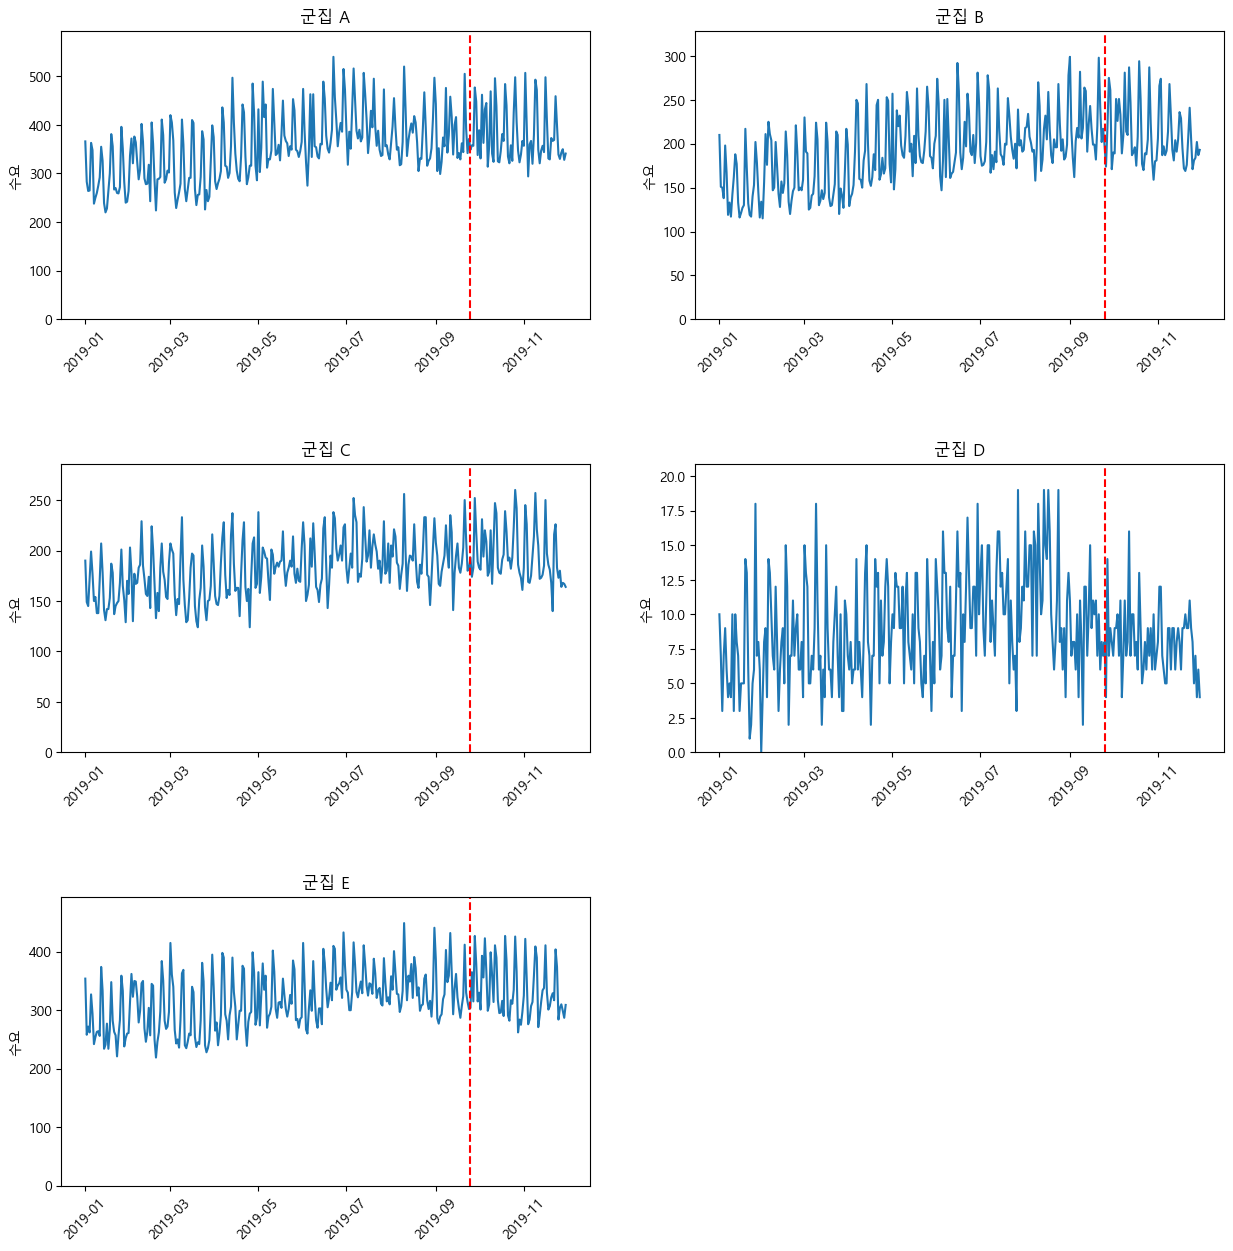

In [83]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=.5)
for i in range(1,6):
    plt.subplot(3,2,i)
    plt.plot(data_[i-1]['Date'],data_[i-1]['Demand'])
    plt.ylabel('수요')
    plt.ylim(0, max(data_[i-1]['Demand'])*1.1)
    plt.xticks(rotation=45)
    plt.title('군집 '+str(cluster_names[i-1]))
    plt.axvline(x = index_to_time[n_split], color = 'r', linestyle='dashed')
plt.show()

# linear model

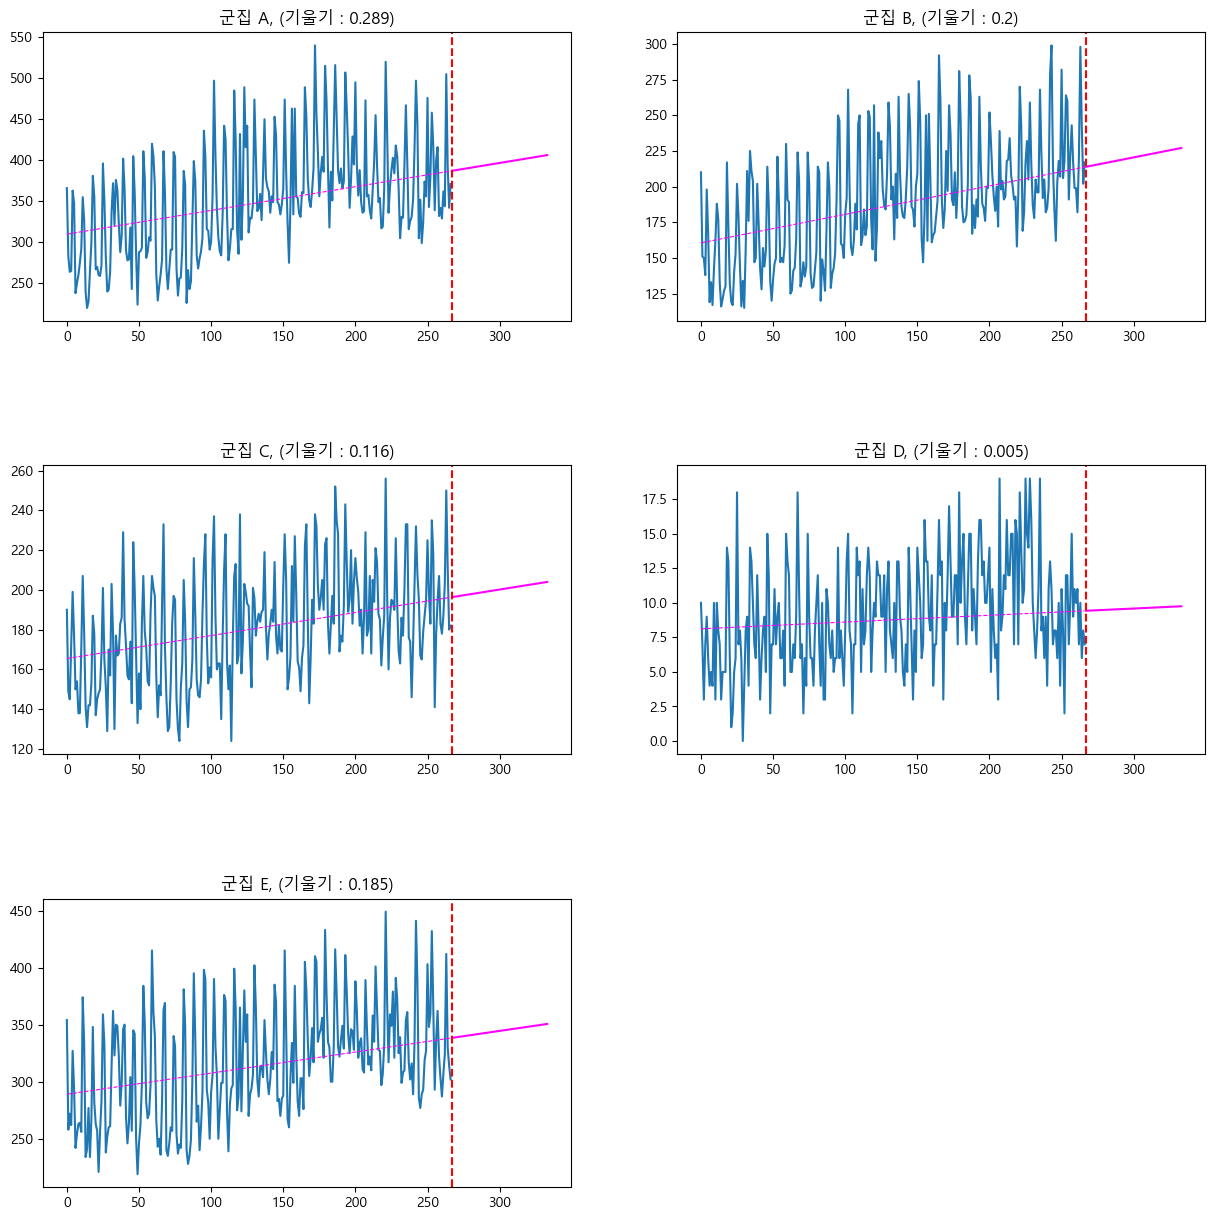

In [118]:
x = np.arange(L)
x = np.expand_dims(x, axis=1)
slopes = []
intercepts = []
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=.5)
for i in range(1,6):
    reg = linear_model.LinearRegression()
    y = data_[i-1]['Demand'].to_numpy()
    reg.fit(x, y)
    slopes.append(reg.coef_[0])
    intercepts.append(reg.intercept_)
    y_hat = reg.coef_*x + reg.intercept_
    plt.subplot(3,2,i)
    plt.plot(x[:n_split], y[:n_split])
    plt.plot(x[:n_split], y_hat[:n_split], c='magenta', linestyle='dashed', linewidth=.8)
    plt.plot(x[n_split:], y_hat[n_split:], c='magenta')
    plt.axvline(x = n_split, color = 'r', linestyle='dashed')
    plt.title('군집 '+str(cluster_names[i-1])+', (기울기 : '+str(round(reg.coef_[0],3))+')')

In [29]:
print(slopes, intercepts, sep='\n')

[0.28922067120297523, 0.1996912991282461, 0.11566202005025852, 0.004898794585093624, 0.18490119398154078]
[309.928590580034, 160.60169809634465, 165.4817946197158, 8.121476450084906, 289.04329251943875]


In [30]:
x = np.arange(L)
x_train = x[:n_split]
x_test = x[n_split:]


In [90]:
MSEs = []
y_test_preds = []
y_train_trues = []
for i in range(1,6):
    x_test = np.arange(L)[n_split:]
    y_test_pred = slopes[i-1]*x_test + intercepts[i-1]
    y_train_true = data_[i-1]['Demand'].to_numpy()[:n_split]
    y_test_true = data_[i-1]['Demand'].to_numpy()[n_split:]
    MSEs.append(mean_squared_error(y_test_pred, y_test_true))
    y_test_preds.append(y_test_pred)
    y_train_true = list(map(float, y_train_true))
    y_train_trues.append(y_train_true)
for i in range(1,6):
    print("MSE of cluster" , cluster_names[i-1] , ":", MSEs[i-1])

MSE of cluster A : 3653.4290295220835
MSE of cluster B : 1362.0973277991213
MSE of cluster C : 806.5575997938831
MSE of cluster D : 8.011342006647395
MSE of cluster E : 2295.493395527923


In [123]:
from statistics import mean
mean_y_train_trues = [mean(y_train_true) for y_train_true in y_train_trues]
mean_y_test_preds = [mean(y_test_pred) for y_test_pred in y_test_preds]
increasing_ratios = np.array(mean_y_test_preds)/np.array(mean_y_train_trues)
result = pd.DataFrame({#'MSE':MSEs,
                        '학습 데이터의 실제값 평균':mean_y_train_trues,
                        '테스트 데이터의 예측값 평균':mean_y_test_preds,
                        '증가비율':increasing_ratios}, index=['A','B','C','D','E'])
result.index.name='군집'
result.round(4)

,학습 데이터의 실제값 평균,테스트 데이터의 예측값 평균,증가비율
군집,,,
A,352.6742,396.6948,1.1248
B,189.8240,220.5091,1.1617
C,181.8502,200.1804,1.1008
D,9.1610,9.5911,1.0469
E,316.1648,344.5137,1.0897


In [99]:
print('total MSE:', round(mean(MSEs), 4))

total MSE: 1625.1177
